#Email Classification
Let us classify emails into categories like Gmail.

## Dataset
You can either create your own dataset or use ours. [Click here](https://drive.google.com/file/d/1woXRa6KIBxoB-UOoJhUj1uEQgoQ62H95/view?usp=sharing) to download the dataset.

## 1. Creating a dataset
1. Make sure the gmail tabs is enabled. Follow the steps in [this link](https://www.maketecheasier.com/configure-tabbed-inbox-in-gmail/) if it's not enabled. 
2. Next create new labels for each category
![alt text](https://i.imgur.com/24csC53.gif)
3. Download the emails using [this script](https://gist.github.com/PandaWhoCodes/78d7ede9267a62f903d05fa4e11f2acd) and process them using [this script](https://gist.github.com/PandaWhoCodes/ddd0786b55dd2a791762d795850c08ce).
upload the json file to your **data folder**.

## 2. Loading the Dataset


In [1]:
import json
with open("mails.json") as f:
  data = json.load(fp=f)

## 3. import pandas as pd
Getting only the subject line and storing the data in a pandas dataframe.

In [2]:
import pandas as pd

primary_mail_subjects = [mail["subject"] for mail in data["primary"]]
promotional_mails_subjects = [mail["subject"] for mail in data["promotional_mails"]]
social_mails_subjects = [mail["subject"] for mail in data["social_mails"]]

print(len(primary_mail_subjects))
print(len(promotional_mails_subjects))
len(social_mails_subjects)

2001
3159


597

To avoid bias towards a particular catgory, we will only take 597 mails from each category 

In [3]:
primary_mail_subjects = primary_mail_subjects[::-1][:597]
promotional_mails_subjects = promotional_mails_subjects[::1][:597]

Converting and combining into one dataframe

In [4]:
primary_df = pd.DataFrame(primary_mail_subjects,columns=["subject"])
primary_df["category"] = 0
promotional_df = pd.DataFrame(promotional_mails_subjects,columns=["subject"])
promotional_df["category"] = 1
social_df = pd.DataFrame(social_mails_subjects,columns=["subject"])
social_df["category"] = 2
data = pd.concat([social_df, promotional_df,primary_df], ignore_index=True)
data.head()

,subject,category
0,The Screen Patti just uploaded a video,2
1,Congratulate Bonskey Samson Samuel and 2...,2
2,The Screen Patti just uploaded a video,2
3,Fabin Services's invitation is waiting for you...,2
4,Magesh Tweeted: on chrome,2


## 4. Training


### Importing useful libraries

In [5]:
import numpy as np

from sklearn.feature_extraction.text import  TfidfTransformer,TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


### Download nltk [lemmas](https://en.wikipedia.org/wiki/Lemma_(morphology)) and stop words

In [6]:
%%capture
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Kishore
[nltk_data]     Balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kishore
[nltk_data]     Balaji\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


### Preprocessing text

1. lemma is a canonical form of the word. So words like "says" will become "say".
2. convert text to lower case



In [7]:
def pre_process(text):
    wnl = WordNetLemmatizer()
    words_list = (str(text).lower()).split()
    final_words = [wnl.lemmatize(word) for word in words_list if word not in stopwords.words('english')]
    final_words_str = str((" ".join(final_words)))
    return final_words_str

In [8]:
data['subject'] = data["subject"].apply(pre_process)

### Splitting into test and train data

The computer cannot understand text, we need to represent text in numbers. Let us go step by step on how to perform that.

---
We will be using Tfidf to convert our words unto vectors.



In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['subject'],data['category'],random_state = 42, test_size=0.20)
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

## 5. Testing


In [11]:
predicted = rf_clf.predict(X_test_tfidf)
acc = np.mean(predicted == y_test)
print("Accuracy:",acc)

Accuracy: 0.8189415041782729


In [12]:
test_set = [
    'Goodreads Newsletter: October 15, 2019',
    'Your receipt for Swiggy order 55519927123 from Oct 30,2019',
    'Congratulations, you now have 5k JPMiles. Redeem Now',
    'Fabin Services invitation is waiting for you	',
    'Ashish, BoJack Horseman Season 6 is now on Netflix',
    'Data Science Horror Stories'
]

In [13]:
final_test = tfidf.transform(test_set)
final_test.shape

(6, 2502)

In [14]:
categories = ["primary","promotional_mails","social_mails"]
classes = [categories[category] for category in rf_clf.predict(final_test)]
print(classes)

['social_mails', 'primary', 'promotional_mails', 'social_mails', 'promotional_mails', 'promotional_mails']


Let's try with another classifier

In [15]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_tfidf, y_train)
predicted = sgd_clf.predict(X_test_tfidf)
np.mean(predicted == y_test)


0.841225626740947

## 6. Confusion Matrix

A confusion matrix is a summary of prediction results on a classification problem.
The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
The confusion matrix shows the ways in which your classification model is confused when it makes predictions.


![alt text](https://pbs.twimg.com/media/EIWZ-e_XkAIEbOq?format=png&name=small)

For a multiclass confusion matrix
![alt text](https://www.researchgate.net/publication/320995731/figure/tbl3/AS:668660284792842@1536432443377/Confusion-matrix-having-3-classes.png)

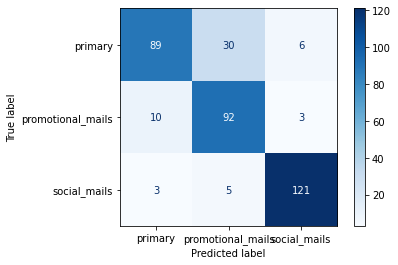

In [20]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(sgd_clf, X_test_tfidf, y_test,
                                 display_labels=categories,
                                 cmap=plt.cm.Blues)
plt.show()


## Precision, Recall, Accuracy and F1 score

![alt text](https://qphs.fs.quoracdn.net/main-qimg-91aaad3402ca66e8f1d451a56cad7539.webp)

precision tells you **how many of the selected objects were correct**. That is the green part inside the circle divided by everything inside the circle. Recall tells you **how many of the objects that should have been selected were actually selected**. That is the green part inside the circle divided by the dark grey part.

Precision and recall counter each other, that is, increasing one of them reduces the other.

Let’s look at the extreme cases: if you select almost everything, the precision is very low, while the recall is very high; if you select almost nothing, precision is very high, while the recall is very low. Therefore, the goal is to have some sort of a balance between the two. The most common way to do this is to use **F-1 score**, which is the harmonic mean of **precision and recall**, so that if either precision or recall is too low, F-1 score is too low. The goal of maximizing the F-1 score ensures that we get a reasonably high precision and recall. 


For rare cancer data modeling, anything that doesn't account for false-negatives is a crime. Recall is a better measure than precision



In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.841226
Precision: 0.841226
Recall: 0.841226
F1 score: 0.841226


# Hyper Parameter Tuning

A hyperparameter is a parameter whose value is set before the learning process begins.Hyperparameter tuning is choosing a set of optimal hyperparameters for a learning algorithm

**Grid search** is a traditional way to perform hyperparameter optimization. It works by searching **exhaustively** through a specified subset of hyperparameters.
Using sklearn’sGridSearchCV, we first define our grid of parameters to search over and then run the grid search.


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 1.0),
    'vect__max_features': (None, 1000, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.1, 0.01, 0.001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50),
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, refit=True)

grid_search.fit(np.array(data['subject']), np.array(data['category']))
print("Best Score: %0.3f\n-------------------------------------------" % grid_search.best_score_)
print("Best Parameters:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    5.6s


Best Score: 0.838
-------------------------------------------
Best Parameters:
	clf__alpha: 0.001
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__max_features: 5000
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   11.9s finished


In [23]:
test_set = [
    'Goodreads Newsletter: October 15, 2019',
    'Your receipt for Swiggy order 55519927123 from Oct 30,2019',
    'Congratulations, you now have 5k JPMiles. Redeem Now',
    'Fabin Services invitation is waiting for you	',
    'Ashish, BoJack Horseman Season 6 is now on Netflix',
    'Data Science Horror Stories'
]

In [24]:
classes = [categories[category] for category in grid_search.best_estimator_.predict(np.array(test_set))]
print(classes)

['social_mails', 'primary', 'promotional_mails', 'social_mails', 'promotional_mails', 'primary']
